In [1]:
# Import the drive module
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNet  # Changed to MobileNet
from sklearn.metrics import classification_report, confusion_matrix
import PIL
import PIL.Image

In [3]:
# Load all the images
train_dir = "/content/drive/MyDrive/IND_Currency_Dataset/IND_Currency_Dataset/train"
test_dir = "/content/drive/MyDrive/IND_Currency_Dataset/IND_Currency_Dataset/test"
TARGET_SIZE = 224
BATCH_SIZE = 64

In [4]:
# Data augmentation and loading
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="training",
    shuffle=True,
    target_size=(TARGET_SIZE, TARGET_SIZE)
)

print(train_generator.class_indices)

Found 1939 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [5]:
# Using MobileNet model for training (instead of VGG19)
base_model = MobileNet(weights='imagenet', input_shape=(TARGET_SIZE, TARGET_SIZE, 3), include_top=False)  # Changed to MobileNet
base_model.trainable = False

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="validation",
    shuffle=False,
    target_size=(TARGET_SIZE, TARGET_SIZE)
)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Found 484 images belonging to 2 classes.


In [6]:
# Adding a model on top
inputs = tf.keras.Input(shape=(TARGET_SIZE, TARGET_SIZE, 3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
output = tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

# Compile the model
opt = tf.keras.optimizers.Adam()
cce = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=cce, metrics=['accuracy'])

# Define callbacks
checkpoint_filepath = 'model.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          16,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,245,298 (12.38 MB)

 Trainable params: 16,434 (64.20 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [7]:
# Create a new test generator BEFORE the training loop
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size=(TARGET_SIZE, TARGET_SIZE),
    shuffle=False  # We don't shuffle the test data for evaluation
)

# Lists to store training/validation/test accuracy and loss after each epoch
train_acc_per_epoch = []
val_acc_per_epoch = []
train_loss_per_epoch = []
val_loss_per_epoch = []
test_acc_per_epoch = []
test_loss_per_epoch = []

EPOCHS = 10
NUM_STEPS = train_generator.samples // BATCH_SIZE
VAL_NUM_STEPS = validation_generator.samples // BATCH_SIZE



Found 177 images belonging to 2 classes.


In [8]:
# Train the model
for epoch in range(EPOCHS):
    # Train the model for one epoch
    history = model.fit(
        train_generator,
        epochs=1,
        steps_per_epoch=NUM_STEPS,
        validation_data=validation_generator,
        validation_steps=VAL_NUM_STEPS,
        callbacks=[reduce_lr, model_checkpoint_callback]
    )

    # Store training and validation metrics
    train_acc_per_epoch.append(history.history['accuracy'][0])  # Training accuracy for this epoch
    val_acc_per_epoch.append(history.history['val_accuracy'][0])  # Validation accuracy for this epoch
    train_loss_per_epoch.append(history.history['loss'][0])  # Training loss for this epoch
    val_loss_per_epoch.append(history.history['val_loss'][0])  # Validation loss for this epoch

    # Evaluate on the test set at the end of each epoch
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)

    # Store test metrics
    test_acc_per_epoch.append(test_accuracy)
    test_loss_per_epoch.append(test_loss)

    # Print progress for the current epoch
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 251s 8s/step - accuracy: 0.8366 - loss: 0.4941 - val_accuracy: 0.9152 - val_loss: 0.2566 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step - accuracy: 0.8958 - loss: 0.2560
Epoch 1/10
Test Loss: 0.2075, Test Accuracy: 0.9219
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9716 - loss: 0.0858 - val_accuracy: 0.9286 - val_loss: 0.2155 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step - accuracy: 0.8958 - loss: 0.2278
Epoch 2/10
Test Loss: 0.1736, Test Accuracy: 0.9219
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9776 - loss: 0.0611 - val_accuracy: 0.8862 - val_loss: 0.3258 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step - accuracy: 0.9792 - loss: 0.0732
Epoch 3/10
Test Loss: 0.0620, Test Accuracy: 0.9844
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9842 - loss: 0.0516 - val_accuracy: 0.8750 - val_loss: 0.3247 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step - accuracy: 0.9792 - loss: 0.

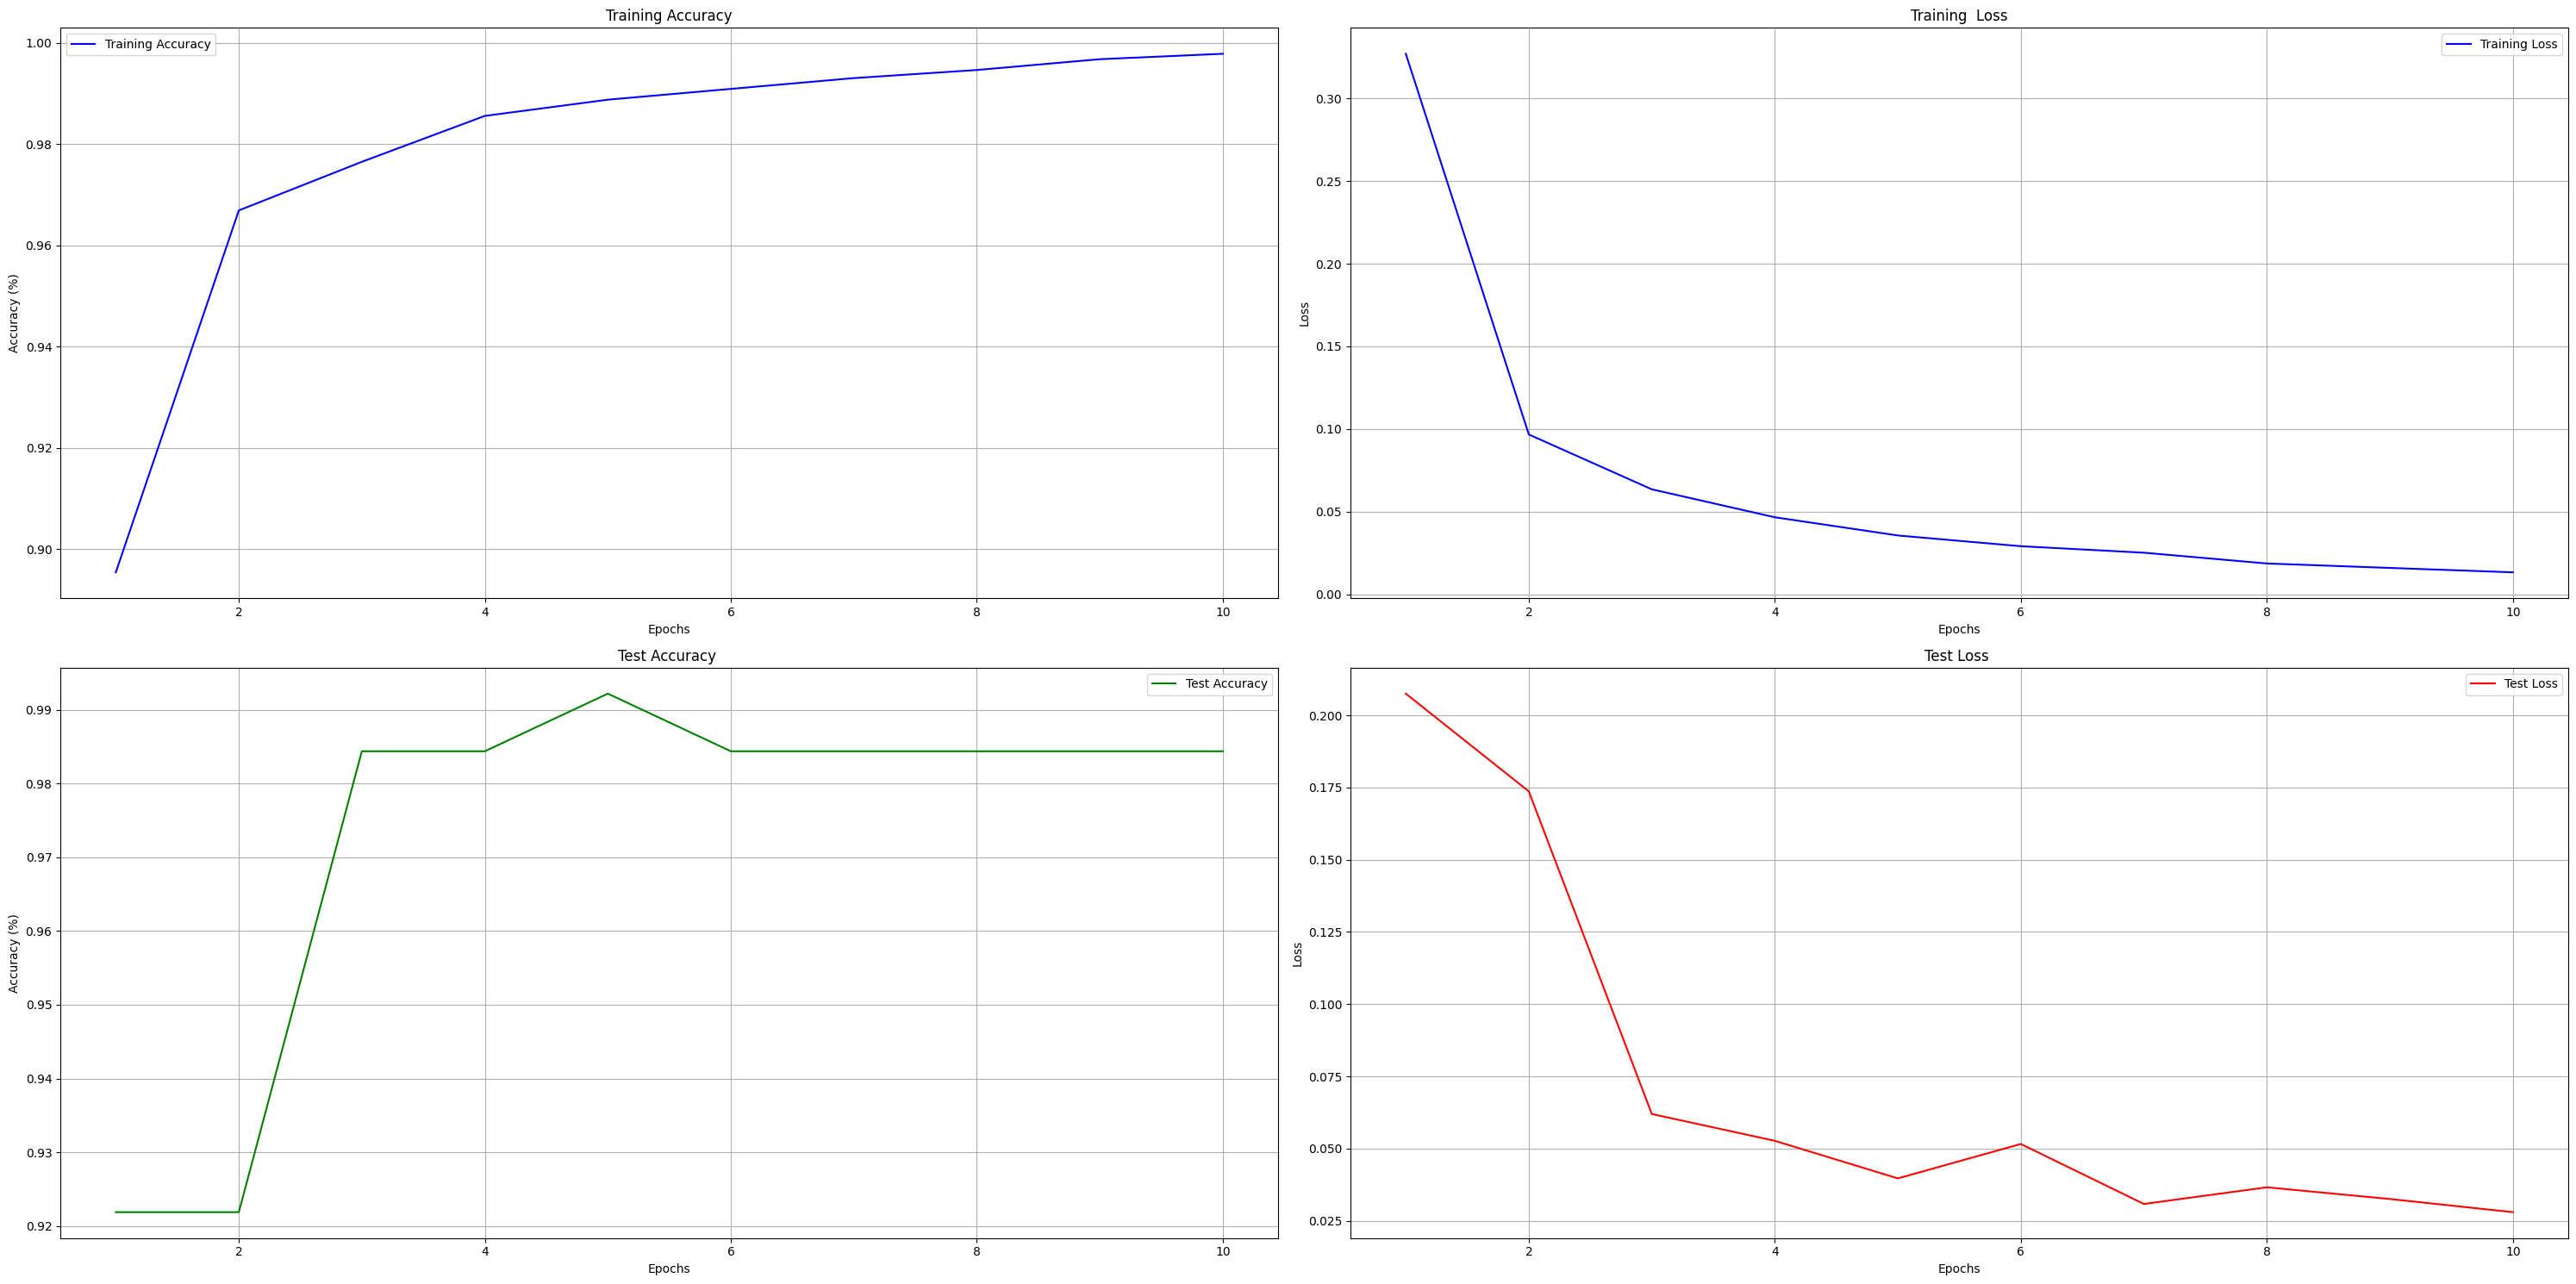

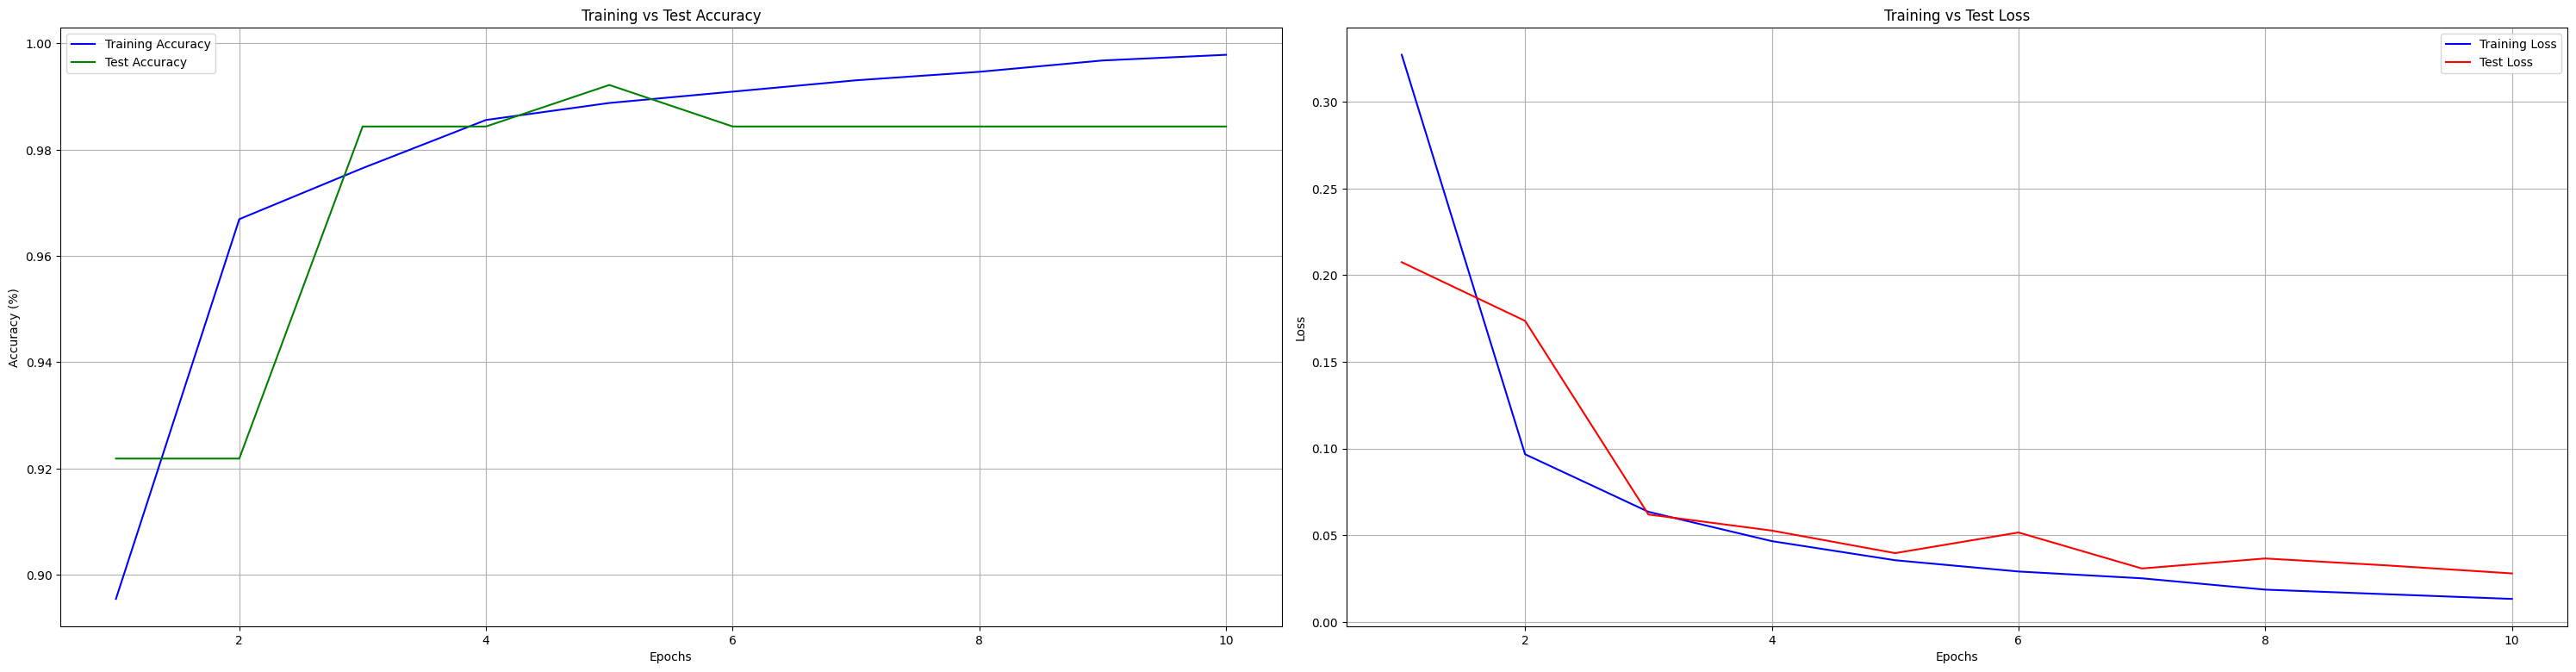

Final Model Loss: 0.0133
Final Model Accuracy: 0.9979


In [9]:
# Plot 1: Training vs Validation Accuracy
plt.figure(figsize=(30, 15))

plt.subplot(2, 2, 1)
plt.plot(range(1, EPOCHS+1), train_acc_per_epoch, label='Training Accuracy', color='blue')
#plt.plot(range(1, EPOCHS+1), val_acc_per_epoch, label='Validation Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# Plot 2: Training vs Validation Loss
plt.subplot(2, 2, 2)
plt.plot(range(1, EPOCHS+1), train_loss_per_epoch, label='Training Loss', color='blue')
#plt.plot(range(1, EPOCHS+1), val_loss_per_epoch, label='Validation Loss', color='orange')
plt.title('Training  Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot 3: Test Accuracy per Epoch
plt.subplot(2, 2, 3)
plt.plot(range(1, EPOCHS+1), test_acc_per_epoch, label='Test Accuracy', color='green')
plt.title('Test Accuracy ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# Plot 4: Test Loss per Epoch
plt.subplot(2, 2, 4)
plt.plot(range(1, EPOCHS+1), test_loss_per_epoch, label='Test Loss', color='red')
plt.title('Test Loss ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
plt.figure(figsize=(30, 15))

# Plot 5: Training vs Test Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, EPOCHS+1), train_acc_per_epoch, label='Training Accuracy', color='blue')
plt.plot(range(1, EPOCHS+1), test_acc_per_epoch, label='Test Accuracy', color='green')
plt.title('Training vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# Plot 6: Training vs Test Loss
plt.subplot(2, 2, 4)
plt.plot(range(1, EPOCHS+1), train_loss_per_epoch, label='Training Loss', color='blue')
plt.plot(range(1, EPOCHS+1), test_loss_per_epoch, label='Test Loss', color='red')
plt.title('Training vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Adjust layout to ensure all plots fit nicely
plt.tight_layout()

# Show the plots
plt.show()

# Print final model loss and accuracy
final_loss = history.history['loss'][-1]  # Final training loss (from the last epoch)
final_accuracy = history.history['accuracy'][-1]  # Final training accuracy (from the last epoch)


# Print final model loss and accuracy
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
print(f'Final Model Loss: {final_loss:.4f}')
print(f'Final Model Accuracy: {final_accuracy:.4f}')
